In [117]:
# !pip install transformers

In [118]:
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
# import joblib
import joblib

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/marcelo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [119]:
# df_arxiv = pd.read_json('./dataset/arxiv-metadata-oai-snapshot.json', lines=True)
# read the first 5 lines
# df_arxiv = pd.read_json('./dataset/arxiv-metadata-oai-snapshot.json', lines=True, nrows=5000)


In [120]:
# Initialize an empty dataframe to store the processed data
df_processed = pd.DataFrame()

# Define the batch size
batch_size = 30000

# Define the total number of rows in the dataset
total_rows = 0

# Iterate over the dataset in batches
for chunk in pd.read_json('./dataset/arxiv-metadata-oai-snapshot.json', lines=True, chunksize=batch_size):
    # Perform data preprocessing operations on each chunk
    chunk_processed = chunk.dropna(subset=['title','abstract', 'journal-ref'])[['title','abstract', 'journal-ref']]

    # Concatenate the processed chunk to the main dataframe
    df_processed = pd.concat([df_processed, chunk_processed], ignore_index=True)

    # # Update the total number of rows processed
    total_rows += len(chunk_processed)


    # # Check if the desired number of rows has been reached
    if total_rows >= batch_size*2:
        break

In [121]:
df_arxiv = df_processed
df_arxiv['title_abstract'] = df_arxiv['title'] + ' ' + df_arxiv['abstract']
del(df_processed)

In [122]:
df_arxiv

,title,abstract,journal-ref,title_abstract
0,Calculation of prompt diphoton production cros...,A fully differential calculation in perturba...,"Phys.Rev.D76:013009,2007",Calculation of prompt diphoton production cros...
1,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,In this paper we show how to compute the $\L...,"Illinois J. Math. 52 (2008) no.2, 681-689",From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...
2,Polymer Quantum Mechanics and its Continuum Limit,A rather non-standard quantum representation...,"Phys.Rev.D76:044016,2007",Polymer Quantum Mechanics and its Continuum Li...
3,Numerical solution of shock and ramp compressi...,A general formulation was developed to repre...,"Journal of Applied Physics, vol 104, 073536 (2...",Numerical solution of shock and ramp compressi...
4,"The Spitzer c2d Survey of Large, Nearby, Inste...",We discuss the results from the combined IRA...,"Astrophys.J.663:1149-1173,2007","The Spitzer c2d Survey of Large, Nearby, Inste..."
...,...,...,...,...
61054,The photon absorption edge in superconductors ...,Opening of a gap in the low-energy excitatio...,"Phys. Rev. B 80, 205416 (2009)",The photon absorption edge in superconductors ...
61055,Cosmological Constant Behavior in DBI Theory,Cosmological constant behavior can be realiz...,"Phys. Lett. B684:181-184,2010",Cosmological Constant Behavior in DBI Theory ...
61056,Constraints on dark matter particles charged u...,In order to accommodate increasingly tighter...,"JCAP 0906:023,2009",Constraints on dark matter particles charged u...
61057,"Cosmological Constant, Classical ""Vacuum"" and ...",We show that Cosmological Constant (CC) is n...,"Proceedings P.I.R.T Budapest, 4-6 September 20...","Cosmological Constant, Classical ""Vacuum"" and ..."


In [123]:
df_arxiv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61059 entries, 0 to 61058
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           61059 non-null  object
 1   abstract        61059 non-null  object
 2   journal-ref     61059 non-null  object
 3   title_abstract  61059 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


In [124]:
df_arxiv["journal-ref"].value_counts()

Dans Design, Automation and Test in Europe - DATE'05, Munich :\n  Allemagne (2005)                                               128
Dans Symposium on Design, Test, Integration and Packaging of\n  MEMS/MOEMS - DTIP 2008, Nice : France (2008)                      77
Dans Symposium on Design, Test, Integration and Packaging of\n  MEMS/MOEMS - DTIP 2007, Stresa, lago Maggiore : Italie (2007)     66
Dans Symposium on Design, Test, Integration and Packaging of\n  MEMS/MOEMS - DTIP 2006, Stresa, Lago Maggiore : Italie (2006)     49
Dans Design, Automation and Test in Europe | Designers'Forum -\n  DATE'05, Munich : Allemagne (2005)                              41
                                                                                                                                ... 
Electronic Journal of Statistics 2008, Vol. 2, 40-62                                                                               1
Oriental Journal of Physics 3(1), 1-10 (2011)                        

In [125]:
import re
import pandas as pd
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

def remove_numbers_and_special_chars(string):
    if pd.isnull(string):
        return string
    output = re.sub(r'[\d()\-\:,]+', '', string)
    output = re.sub(r'  ', ' ', output)
    output = output.strip()
    return output

df_arxiv['title_abstract'] = df_arxiv['title_abstract'].apply(remove_stopwords)

df_arxiv['journal-ref'] = df_arxiv['journal-ref'].apply(remove_stopwords)
df_arxiv['journal-ref-no-numbers'] = df_arxiv['journal-ref'].apply(remove_numbers_and_special_chars)

In [126]:
df_arxiv['journal-ref-no-numbers'].value_counts()

Phys.Rev.D                                                                                               5149
JHEP                                                                                                     2609
Phys . Rev . B                                                                                           2441
Astrophys.J.                                                                                             2021
Phys . Rev . Lett .                                                                                      1916
                                                                                                         ... 
Proceedings th IEEE ICACT  Volume February  Phoenix Park Korea  pp .                                        1
Proceedings IEEE International Conference Consumer Electronics IEEE ICCE  January  Las Vegas USA pp .       1
Proceedings th IEEE ICACT  Volume February   Phoenix Park Korea pp .                                        1
Tech . Dig

In [127]:
from fuzzywuzzy import fuzz
import pandas as pd

def group_journal_references(df, ref_column, threshold=80, group_column='Group'):
    """
    Groups similar journal references in a pandas DataFrame based on a reference column.

    Args:
        df (pandas.DataFrame): DataFrame containing the journal references.
        ref_column (str): Name of the column containing the journal references.
        threshold (int, optional): Similarity threshold for fuzzy matching. Defaults to 80.
        group_column (str, optional): Name of the new column to store the group names. Defaults to 'Group'.

    Returns:
        pandas.DataFrame: DataFrame with the new group column added.
    """
    groups = []
    new_column = []

    for ref in df[ref_column]:
        found_group = False

        for group in groups:
            if ref in group:
                new_column.append(group[0])
                found_group = True
                break

        if not found_group:
            for group in groups:
                for ref_in_group in group:
                    similarity_score = fuzz.ratio(ref, ref_in_group)
                    # similarity_score = SequenceMatcher(None, ref, ref_in_group).ratio()
                    if similarity_score >= threshold:
                        group.append(ref)
                        new_column.append(group[0])  # Store the group name in the new column
                        found_group = True
                        break
                if found_group:
                    break

        if not found_group:
            groups.append([ref])
            new_column.append(ref)  # Store the reference itself as the group name

    df[group_column] = new_column
    return df

df_arxiv = group_journal_references(df_arxiv, 'journal-ref-no-numbers', threshold=80, group_column='Group')

In [128]:
print(len(df_arxiv['Group'].unique()))

6086


In [129]:
print(len(df_arxiv))

61059


In [130]:
df_arxiv['Group'].value_counts()

# count the percentage of each group
df_arxiv['Group'].value_counts(normalize=True)[:50]

# count the number of group with 1 reference
# (df_arxiv['Group'].value_counts() == 1).sum()


Phys.Rev.D                                                                                       0.183691
Phys . Rev . Lett .                                                                              0.048150
JHEP                                                                                             0.042778
Phys . Rev . B                                                                                   0.041878
Astrophys.J.                                                                                     0.041173
Phys.Lett.B                                                                                      0.026646
AIP Conf.Proc.                                                                                   0.015854
Nucl.Phys.A                                                                                      0.015706
Eur . Phys . J . B                                                                               0.015149
Class.Quant.Grav. SS                          

<AxesSubplot: >

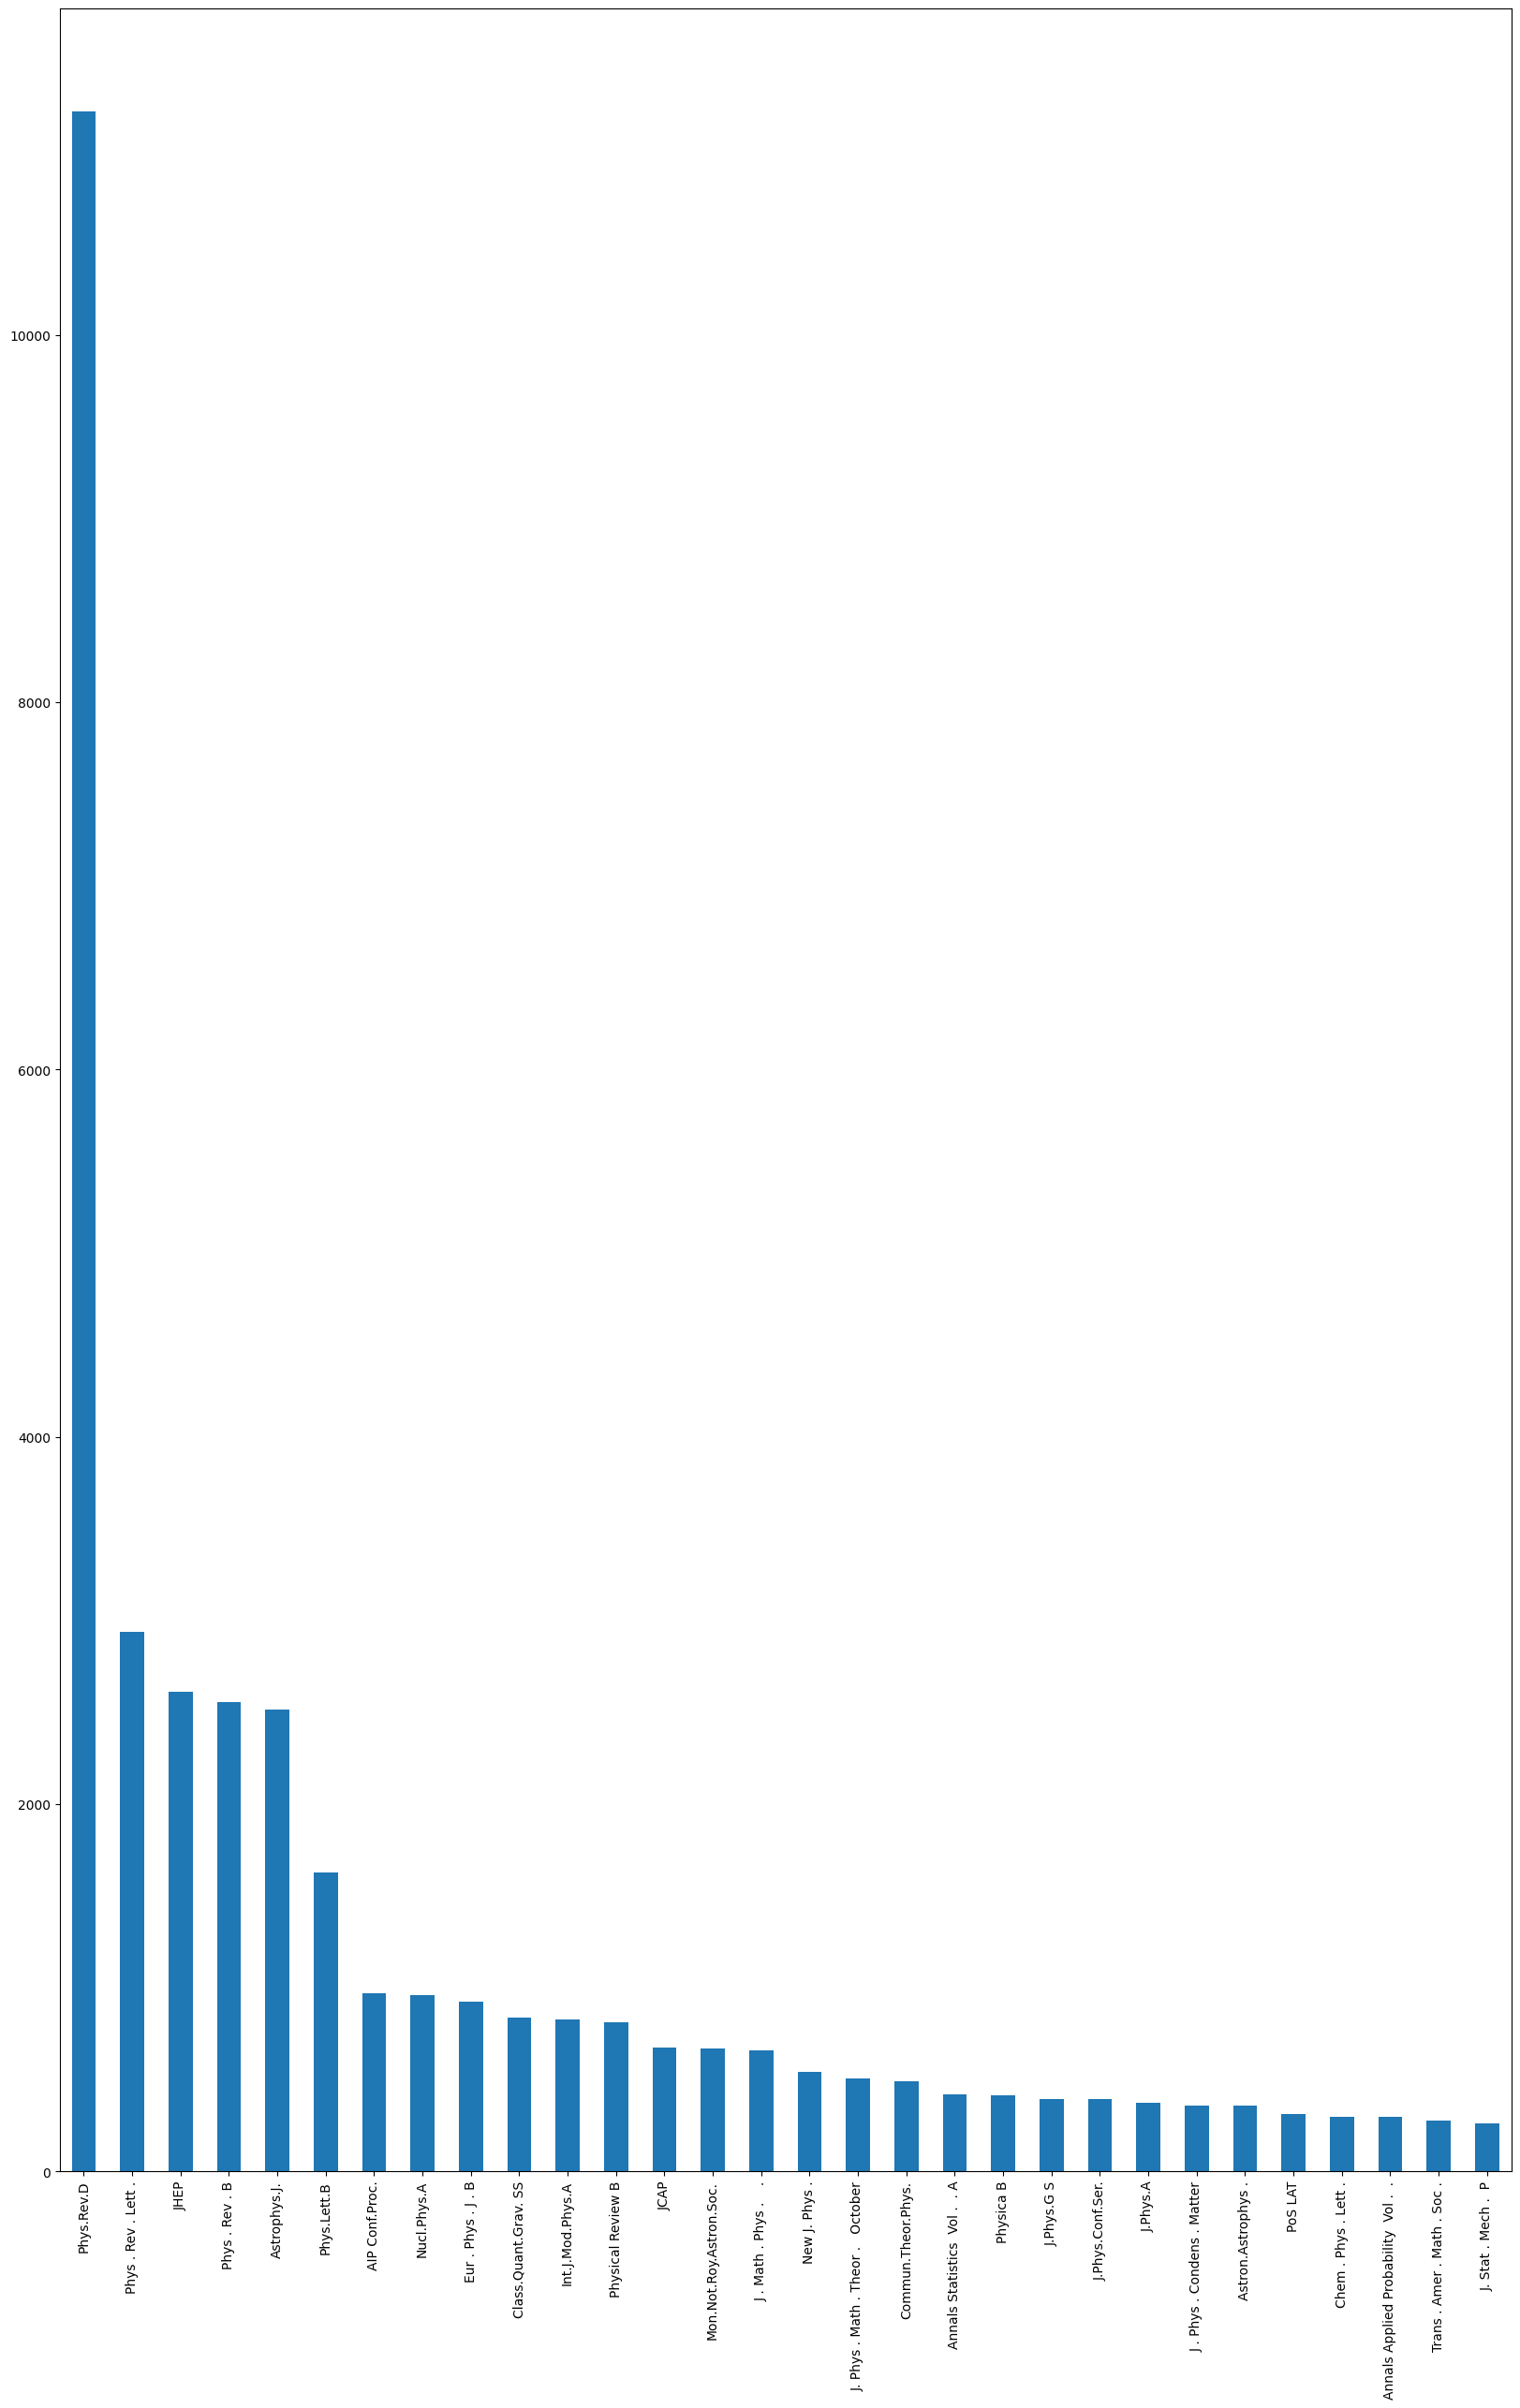

In [131]:
# make a graph with the value counts
df_arxiv['Group'].value_counts()[:30].plot(kind='bar', figsize=(20, 30))

In [132]:
import pandas as pd

# Select the top 30 groups
top_30_groups = df_arxiv['Group'].value_counts().nlargest(30).index
df_arxiv_top30 = df_arxiv[df_arxiv['Group'].isin(top_30_groups)].reset_index(drop=True)

# Find the group with the fewest rows
min_group_count = df_arxiv_top30['Group'].value_counts().min()

# Limit all groups to have the same number of rows
df_arxiv_top30_normalized = df_arxiv_top30.groupby('Group').apply(lambda x: x.sample(n=min_group_count)).reset_index(drop=True)


In [133]:
df_arxiv_top30_normalized['Group'].value_counts()

AIP Conf.Proc.                          259
Annals Applied Probability  Vol .  .    259
PoS LAT                                 259
Physical Review B                       259
Physica B                               259
Phys.Rev.D                              259
Phys.Lett.B                             259
Phys . Rev . Lett .                     259
Phys . Rev . B                          259
Nucl.Phys.A                             259
New J. Phys .                           259
Mon.Not.Roy.Astron.Soc.                 259
JHEP                                    259
JCAP                                    259
J.Phys.G S                              259
J.Phys.Conf.Ser.                        259
J.Phys.A                                259
J. Stat . Mech .  P                     259
J. Phys . Math . Theor .   October      259
J . Phys . Condens . Matter             259
J . Math . Phys .    .                  259
Int.J.Mod.Phys.A                        259
Eur . Phys . J . B              

In [134]:
NUMBER_OF_GROUPS_TO_PREDICT = 5


In [135]:
classes = df_arxiv_top30_normalized['Group'].unique()

In [136]:
classes

array(['AIP Conf.Proc.', 'Annals Applied Probability  Vol .  .',
       'Annals Statistics  Vol .  . A', 'Astron.Astrophys .',
       'Astrophys.J.', 'Chem . Phys . Lett .', 'Class.Quant.Grav. SS',
       'Commun.Theor.Phys.', 'Eur . Phys . J . B', 'Int.J.Mod.Phys.A',
       'J . Math . Phys .    .', 'J . Phys . Condens . Matter',
       'J. Phys . Math . Theor .   October', 'J. Stat . Mech .  P',
       'J.Phys.A', 'J.Phys.Conf.Ser.', 'J.Phys.G S', 'JCAP', 'JHEP',
       'Mon.Not.Roy.Astron.Soc.', 'New J. Phys .', 'Nucl.Phys.A',
       'Phys . Rev . B', 'Phys . Rev . Lett .', 'Phys.Lett.B',
       'Phys.Rev.D', 'Physica B', 'Physical Review B', 'PoS LAT',
       'Trans . Amer . Math . Soc .'], dtype=object)

## Naive Bayes

In [137]:
from sklearn.model_selection import cross_val_score

In [138]:
X_train, X_test, y_train, y_test = train_test_split(df_arxiv_top30_normalized['title_abstract'], df_arxiv_top30_normalized['Group'], test_size=0.2, random_state=42)

In [139]:



classificador = Pipeline([
                        ('meu_vetorizador', CountVectorizer(stop_words='english')),
                        ('meu_classificador', MultinomialNB())
                        ])
# Split the data into training and testing sets


classificador.fit(X_train,y_train)

y_pred = classificador.predict(X_test)
acc = accuracy_score(y_pred,y_test)
print(acc)
naive_bayes_accuracy = acc

probabilities = classificador.predict_proba(X_test)

# Get the top five most probable classes for each sample
top_five_classes = [classificador.classes_[probs.argsort()[-NUMBER_OF_GROUPS_TO_PREDICT:][::-1]] for probs in probabilities]

# Calculate accuracy based on top five predicted classes
correct_predictions = 0

for true_label, predicted_labels in zip(y_test, top_five_classes):
    if true_label in predicted_labels:
        correct_predictions += 1

naive_bayes_top_5_accuracy = correct_predictions / len(y_test)
print("top 5 accuracy: ", naive_bayes_top_5_accuracy)

joblib.dump(classificador, 'nb_classifier.pkl')

0.3918918918918919
top 5 accuracy:  0.7696267696267697


['nb_classifier.pkl']

In [140]:
# test the model with the input 'title_abstract'
title_abstract = 'A new approach to the maximum flow problem'
start_time = time.time()
resposta=classificador.predict([title_abstract])

end_time = time.time()

# Calcular o tempo de inferência em segundos
naive_bayes_tempo_inferencia = end_time - start_time
print("Predição: ", resposta)
print("Tempo de inferência: {:.4f} segundos".format(naive_bayes_tempo_inferencia))


Predição:  ['Annals Statistics  Vol .  . A']
Tempo de inferência: 0.0024 segundos


In [141]:
def intervalo_de_confianca(classificador, X_text, y_test):
    scores = cross_val_score(classificador, X_test, y_test, cv=5, scoring='accuracy')
    mean_accuracy = np.mean(scores)
    std_accuracy = np.std(scores)
    # Calculando o intervalo de confiança de 95%
    confidence_interval = [mean_accuracy - 1.96 * (std_accuracy / np.sqrt(15)), mean_accuracy + 1.96 * (std_accuracy / np.sqrt(15))]
    print('Mean accuracy: ', mean_accuracy)
    print('Standard deviation accuracy: ', std_accuracy)
    print('Confidence interval: ', confidence_interval)
    return mean_accuracy,std_accuracy,confidence_interval


naive_bayes_mean_accuracy,naive_bayes_std_accuracy,naive_bayes_confidence_interval = intervalo_de_confianca(classificador, X_test, y_test)



Mean accuracy:  0.32947826988901563
Standard deviation accuracy:  0.01066953220831939
Confidence interval:  [0.3240787416032087, 0.33487779817482255]


## CNN

In [142]:
df_arxiv_top30_normalized['Group'].value_counts()

AIP Conf.Proc.                          259
Annals Applied Probability  Vol .  .    259
PoS LAT                                 259
Physical Review B                       259
Physica B                               259
Phys.Rev.D                              259
Phys.Lett.B                             259
Phys . Rev . Lett .                     259
Phys . Rev . B                          259
Nucl.Phys.A                             259
New J. Phys .                           259
Mon.Not.Roy.Astron.Soc.                 259
JHEP                                    259
JCAP                                    259
J.Phys.G S                              259
J.Phys.Conf.Ser.                        259
J.Phys.A                                259
J. Stat . Mech .  P                     259
J. Phys . Math . Theor .   October      259
J . Phys . Condens . Matter             259
J . Math . Phys .    .                  259
Int.J.Mod.Phys.A                        259
Eur . Phys . J . B              

In [143]:
import pandas as pd
import tensorflow as tf

from keras.layers import Input, Embedding, Conv1D, GlobalAveragePooling1D, Dense, Activation, AveragePooling1D, TextVectorization
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
from keras.metrics import top_k_categorical_accuracy

In [144]:


def cnn_embedding_softmax_model(vectorize_layer,vocab_size, num_classes):
    # input_layer = Input(shape=(max_len,), dtype=tf.int32)
    input_layer = Input(shape=(1,), dtype=tf.string)
    # x = Embedding(vocab_size, 2)(input_layer)
    x = input_layer 
    x = vectorize_layer(x)
    x = Embedding(vocab_size, 128, name='projecao')(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(num_classes)(x)
    x = Activation('softmax')(x)
    return Model(input_layer, x)


# Pré-processamento
X = df_arxiv_top30_normalized['title_abstract'].values
y = df_arxiv_top30_normalized['Group'].values

# Codificar as classes em números
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

num_classes = len(label_encoder.classes_)
vocab_size = 1000
# vocab_size = 30000
vectorize_layer = TextVectorization(output_mode='int', max_tokens=vocab_size, pad_to_max_tokens=True, output_sequence_length=256)
vectorize_layer.adapt(X_train)

model = cnn_embedding_softmax_model(vectorize_layer,vocab_size, num_classes)

# Compilação do modelo
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Treinamento do modelo
batch_size = 32
epochs = 30

# model.fit(X_train_pad, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test_pad, y_test))
history = model.fit(X_train, y_train, epochs=epochs,verbose=1, validation_data=(X_test, y_test), validation_split=0.1)

# Avaliação do modelo
loss, accuracy = model.evaluate(X_test, y_test)
print("Loss:", loss)
print("Accuracy", accuracy)

from keras.metrics import top_k_categorical_accuracy
def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

predictions = model.predict(X_test)
cnn_top_5_acc = np.mean(np.max(np.equal(np.argsort(predictions)[:, -5:], np.expand_dims(y_test, axis=1)), axis=1))
print("Top-5 Accuracy:", cnn_top_5_acc)
cnn_accuracy = accuracy

Epoch 1/30
195/195 [==============================] - 7s 20ms/step - loss: 3.3847 - accuracy: 0.0541 - val_loss: 3.3536 - val_accuracy: 0.0676
Epoch 2/30
195/195 [==============================] - 2s 10ms/step - loss: 3.2951 - accuracy: 0.0919 - val_loss: 3.2372 - val_accuracy: 0.1255
Epoch 3/30
195/195 [==============================] - 3s 14ms/step - loss: 3.2013 - accuracy: 0.1200 - val_loss: 3.1684 - val_accuracy: 0.1216
Epoch 4/30
195/195 [==============================] - 1s 7ms/step - loss: 3.1257 - accuracy: 0.1673 - val_loss: 3.0912 - val_accuracy: 0.1840
Epoch 5/30
195/195 [==============================] - 2s 12ms/step - loss: 3.0302 - accuracy: 0.2003 - val_loss: 2.9957 - val_accuracy: 0.2053
Epoch 6/30
195/195 [==============================] - 2s 9ms/step - loss: 2.9123 - accuracy: 0.2376 - val_loss: 2.8825 - val_accuracy: 0.2368
Epoch 7/30
195/195 [==============================] - 1s 6ms/step - loss: 2.7873 - accuracy: 0.2741 - val_loss: 2.7699 - val_accuracy: 0.2716
Ep

In [145]:
joblib.dump(label_encoder, 'label_encoder.joblib')


['label_encoder.joblib']

In [146]:
model.save('./cnn_model')

2023-06-05 21:34:46.662081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_9' with dtype string and shape [?,1]
	 [[{{node input_9}}]]
2023-06-05 21:34:46.802035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_9' with dtype string and shape [?,1]
	 [[{{node input_9}}]]
2023-06-05 21:34:46.845591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype string and shape [?,1]
	 [[{{node inputs}}]]
2023-06-05 21:3

INFO:tensorflow:Assets written to: ./cnn_model/assets


INFO:tensorflow:Assets written to: ./cnn_model/assets


In [108]:
import numpy as np
from sklearn.utils import resample

# Função para calcular a acurácia do modelo
def calculate_accuracy(model, X, y):
    y_pred = model.predict(X)
    y_pred_classes = y_pred.argmax(axis=1)
    accuracy = np.mean(y_pred_classes == y)
    return accuracy

def intervalo_de_confianca_keras(model, X_test, y_test):
    n_bootstrap_samples = 1000
    accuracies = []
    for i in range(n_bootstrap_samples):
        X_boot, y_boot = resample(X_test, y_test)
        accuracy = calculate_accuracy(model, X_boot, y_boot)
        accuracies.append(accuracy)

    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)
    confidence_interval = [mean_accuracy - 1.96 * (std_accuracy / np.sqrt(15)), mean_accuracy + 1.96 * (std_accuracy / np.sqrt(15))]
    
    print('Intervalo de confiança de 95%: {}'.format(confidence_interval))
    return mean_accuracy, std_accuracy,confidence_interval

cnn_mean_accuracy,cnn_std_accuracy,cnn_confidence_interval = intervalo_de_confianca_keras(model, X_test, y_test)


17/37 [============>.................] - ETA: 0s

KeyboardInterrupt: 

In [80]:
# test the model with the input 'title_abstract'

start_time = time.time()
resposta=model.predict([title_abstract])

end_time = time.time()

# Calcular o tempo de inferência em segundos
cnn_tempo_de_inferencia = end_time - start_time
print("Predição: ", label_encoder.inverse_transform(resposta.argmax(axis=1))[0])
print("Tempo de inferência: {:.4f} segundos".format(cnn_tempo_de_inferencia))

1/1 [==============================] - 0s 34ms/step
Predição:  J.Phys.Conf.Ser.
Tempo de inferência: 0.0819 segundos


## CNN with Bert Model

In [66]:
from transformers import TFBertModel, BertTokenizer


In [199]:
from transformers import BertTokenizer, TFBertModel
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Input, GlobalAveragePooling1D

def train_cnn_bert(df):
    # Pré-processamento
    X = df['title_abstract'].values
    y = df['Group'].values

    # Codificar as classes em números
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

    # Divisão em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    num_classes = len(label_encoder.classes_)
    vocab_size = 1000
    # Load the pre-trained BERT model
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    bert_model = TFBertModel.from_pretrained('bert-base-uncased')

    # Preprocess the text data
    max_length = 512

    def preprocess_text(text):
        tokens = tokenizer.encode_plus(text, add_special_tokens=True, max_length=max_length, truncation=True, padding='max_length', return_tensors='tf')
        return tokens.input_ids, tokens.attention_mask

    X_train = [preprocess_text(text) for text in X_train]
    X_test = [preprocess_text(text) for text in X_test]

    # Prepare the input tensors
    input_ids_train = tf.concat([item[0] for item in X_train], axis=0)[:50]
    attention_masks_train = tf.concat([item[1] for item in X_train], axis=0)

    input_ids_test = tf.concat([item[0] for item in X_test], axis=0)
    attention_masks_test = tf.concat([item[1] for item in X_test], axis=0)

    # Embed the text using BERT
    train_outputs = bert_model([input_ids_train, attention_masks_train])
    train_embeddings = train_outputs.pooler_output

    test_outputs = bert_model([input_ids_test, attention_masks_test])
    test_embeddings = test_outputs.pooler_output

    # Build the CNN model
    input_shape = train_embeddings.shape[1]
    print(input_shape)
    cnn_input = Input(shape=(input_shape,))
    output = Dense(num_classes, activation='softmax')(cnn_input)

    cnn_bert_model = Model(inputs=cnn_input, outputs=output)

    # Compile and train the model
    batch_size = 32
    epochs = 10

    cnn_bert_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    cnn_bert_model.fit(train_embeddings, y_train, batch_size=batch_size, epochs=epochs, validation_data=(test_embeddings, y_test))

    # Evaluate the model
    y_pred = cnn_bert_model.predict(test_embeddings)
    y_pred_classes = y_pred.argmax(axis=1)
    y_test_classes = y_test
    
    joblib.dump(tokenizer, 'tokenizer_cnn_bert.joblib')
    
    return cnn_bert_model, test_embeddings

# pipeline = Pipeline([
#     ('meu_vetorizador', BertTokenizer.from_pretrained('bert-base-uncased')),
#     ('meu_classificador', TFBertModel.from_pretrained('bert-base-uncased'))


cnn_bert_model, test_embeddings=train_cnn_bert(df_arxiv_top30_normalized)


2023-06-04 20:54:14.621889: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 93763584 exceeds 10% of free system memory.
2023-06-04 20:54:15.151996: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 93763584 exceeds 10% of free system memory.
2023-06-04 20:54:16.211648: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 93763584 exceeds 10% of free system memory.


In [ ]:
cnn_bert_model.save('./cnn_bert_model')

INFO:tensorflow:Assets written to: ./cnn_bert_model/assets


INFO:tensorflow:Assets written to: ./cnn_bert_model/assets


In [ ]:
bert_mean_accuracy,bert_std_accuracy,bert_confidence_interval = intervalo_de_confianca_keras(cnn_bert_model, test_embeddings, y_test)

NameError: name 'cnn_bert_model' is not defined

### Rede Pré Treinada

In [27]:
from transformers import pipeline

2023-06-05 20:00:24.631149: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-05 20:00:29.733451: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [28]:
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")

In [29]:
def predict_df_bert(length = None):
    classification_results = []
    if length is None:
        length = len(df_arxiv_top30_normalized)
    new_df = df_arxiv_top30_normalized[:length]
    for index, row in new_df.iterrows():
        result = classifier(row['title_abstract'], classes, multi_class=True)
        score = result.get('scores')
        label = result.get('labels')

        if score[0] > score[1]:
            classification = label[0]
        else:
            classification = label[1]

        classification_results.append(classification)
    return classification_results

classification_results = predict_df_bert(length = 1)

The `multi_class` argument has been deprecated and renamed to `multi_label`. `multi_class` will be removed in a future version of Transformers.


In [30]:
accuracies = []
accuracy = np.mean(classification_results == df_arxiv_top30_normalized['Group'][:len(classification_results)].values)
for samples in range(3):
    classification_results = predict_df_bert()
    accuracy = np.mean(classification_results == df_arxiv_top30_normalized['Group'][:len(classification_results)].values)
    accuracies.append(accuracy)

mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
confidence_interval = [mean_accuracy - 1.96 * (std_accuracy / np.sqrt(15)), mean_accuracy + 1.96 * (std_accuracy / np.sqrt(15))]
print('Intervalo de confiança de 95%: {}'.format(confidence_interval))
# write this to a file
with open("accuracy_bert.txt", 'w') as file:
    file.write(str(mean_accuracy))
    file.write('\n')
    file.write(str(std_accuracy))
    file.write('\n')
    file.write(str(confidence_interval))

The `multi_class` argument has been deprecated and renamed to `multi_label`. `multi_class` will be removed in a future version of Transformers.
The `multi_class` argument has been deprecated and renamed to `multi_label`. `multi_class` will be removed in a future version of Transformers.
The `multi_class` argument has been deprecated and renamed to `multi_label`. `multi_class` will be removed in a future version of Transformers.
The `multi_class` argument has been deprecated and renamed to `multi_label`. `multi_class` will be removed in a future version of Transformers.
The `multi_class` argument has been deprecated and renamed to `multi_label`. `multi_class` will be removed in a future version of Transformers.
The `multi_class` argument has been deprecated and renamed to `multi_label`. `multi_class` will be removed in a future version of Transformers.


KeyboardInterrupt: 

In [ ]:
import numpy as np
from scipy import stats

# Function to calculate the mean, standard deviation, and confidence interval
def calculate_statistics(predictions, actual_results):
    # Calculate mean
    mean = np.mean(predictions)

    # Calculate standard deviation
    std = np.std(predictions)

    # Calculate confidence interval
    confidence_interval = stats.t.interval(0.95, len(predictions) - 1, loc=mean, scale=stats.sem(predictions))

    return mean, std, confidence_interval


In [68]:
start = time.time()
result = classifier(title_abstract, classes, multi_class=True)
end = time.time()
bert_tempo_inferencia = end - start
print("tempo de inferência: ", bert_tempo_inferencia)


The `multi_class` argument has been deprecated and renamed to `multi_label`. `multi_class` will be removed in a future version of Transformers.


tempo de inferência:  6.213176727294922


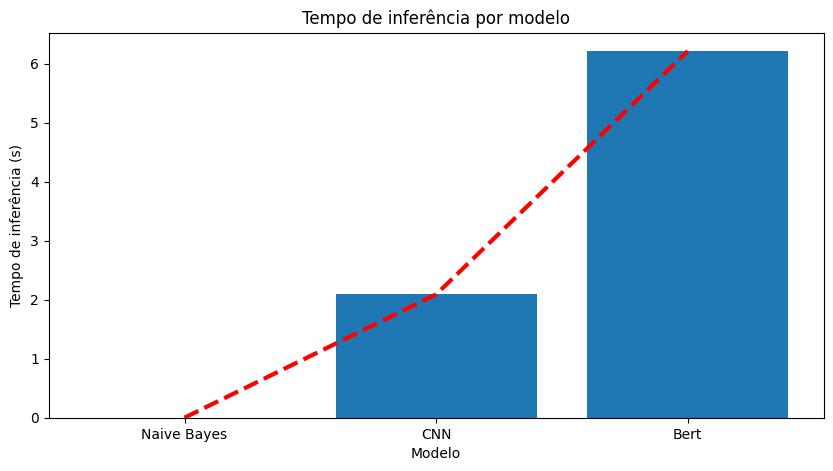

In [77]:
plt.figure(figsize=(10, 5))
plt.bar(['Naive Bayes', 'CNN', 'Bert'], [naive_bayes_tempo_inferencia, cnn_tempo_de_inferencia, bert_tempo_inferencia])
# Adicionar a linha com os mesmos valores
plt.plot(['Naive Bayes', 'CNN', 'Bert'], [naive_bayes_tempo_inferencia, cnn_tempo_de_inferencia, bert_tempo_inferencia], color='red', linestyle='dashed', linewidth=3,)
plt.ylabel('Tempo de inferência (s)')
plt.xlabel('Modelo')
plt.title('Tempo de inferência por modelo')
plt.show()


In [9]:
from keras.models import load_model
from transformers import BertTokenizer, TFBertModel

2023-06-05 20:35:40.379038: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-05 20:35:40.422999: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-05 20:35:40.423344: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-05 20:35:41.315963: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [97]:
model_naive_bayes = joblib.load("nb_classifier.pkl")
model_cnn = load_model("./cnn_model")
# model_cnn_bert = load_model("./cnn_bert_model")
# label_encoder = joblib.load('./label_encoder.joblib')
# tokenizer = joblib.load('./tokenizer_cnn_bert.joblib')

In [98]:
#using the X_test and y_test from the train_test_split
# check the accuracy of the model
# Naive Bayes
y_pred = model_naive_bayes.predict(X_test)
naive_bayes_accuracy = np.mean(y_pred == y_test)
print("Accuracy: %.2f%%" % (naive_bayes_accuracy * 100.0))

# CNN
y_pred = model_cnn.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)
y_pred_classes = label_encoder.inverse_transform(y_pred_classes)
y_test_classes = y_test
cnn_accuracy = np.mean(y_pred_classes == y_test_classes)
print("Accuracy: %.2f%%" % (cnn_accuracy * 100.0))


Accuracy: 0.00%
34/37 [==========================>...] - ETA: 0s

/tmp/ipykernel_13916/1055558237.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  naive_bayes_accuracy = np.mean(y_pred == y_test)


37/37 [==============================] - 0s 3ms/step
Accuracy: 0.00%


Text(0.5, 1.0, 'Acurácia por modelo')

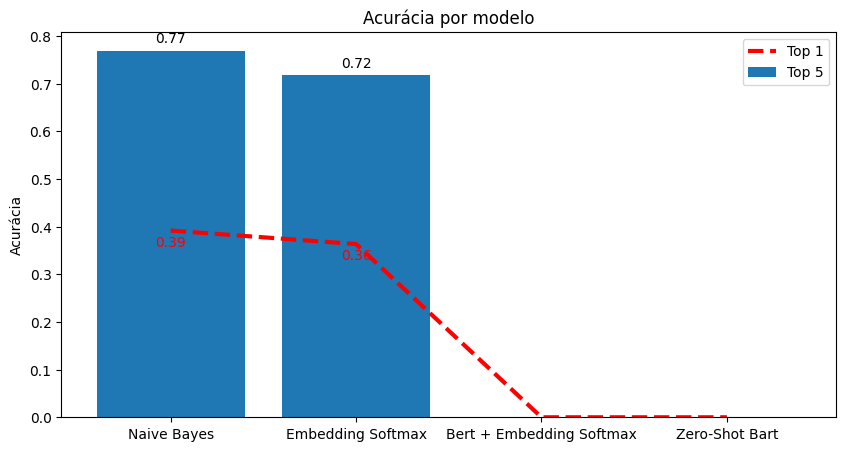

In [147]:
plt.figure(figsize=(10, 5))
plt.bar(['Naive Bayes', 'Embedding Softmax', 'Bert + Embedding Softmax', 'Zero-Shot Bart'], [naive_bayes_top_5_accuracy, cnn_top_5_acc, 0.0, 0.0])
# Adicionar a linha com os mesmos valores
plt.plot(['Naive Bayes', 'Embedding Softmax', 'Bert + Embedding Softmax', 'Zero-Shot Bart'], [naive_bayes_accuracy, cnn_accuracy, 0.0, 0.0], color='red', linestyle='dashed', linewidth=3,)

# Adicionar texto explicativo
plt.text(0, naive_bayes_top_5_accuracy + 0.01, f'{naive_bayes_top_5_accuracy:.2f}', ha='center', va='bottom')
plt.text(1, cnn_top_5_acc + 0.01, f'{cnn_top_5_acc:.2f}', ha='center', va='bottom')
plt.text(0, naive_bayes_accuracy - 0.01, f'{naive_bayes_accuracy:.2f}', ha='center', va='top', color='red')
plt.text(1, cnn_accuracy - 0.01, f'{cnn_accuracy:.2f}', ha='center', va='top', color='red')

# add a legend to the plot
plt.legend(['Top 1', 'Top 5'], loc='upper right')
plt.ylabel('Acurácia')
plt.title('Acurácia por modelo')